<a href="https://colab.research.google.com/github/Karol-Agudelo/Estad-stica-1-/blob/main/BONUS%20PRIMER%20PARCIAL-T%C3%93PICOS%20EN%20ESTAD%C3%8DSTICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

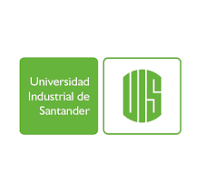
# **Universidad Industrial de Santander**

**Facultad de Ciencias**

**Estadística I**

Parte práctica segudno parcial

Karol Natalia Agudelo Salgado

2211979     

# **1. Introducción**

Este documento presenta la parte práctica del primer examen parcial para la asignatura Tópicos en Estadística.

El trabajo se centra en un proyecto de análisis y predicción de series temporales cuyo objetivo es pronosticar los casos diarios de COVID-19 (identificados como "Frecuencia") a lo largo del tiempo. La metodología emplea técnicas de Deep Learning, específicamente utilizando una Red Neuronal Recurrente (GRU). El proceso incluye el preprocesamiento de los datos, la normalización de la serie temporal y la estructuración de la información en ventanas de 30 días para el entrenamiento del modelo.

Finalmente, el documento demuestra que el modelo desarrollado exhibe una alta capacidad predictiva, logrando capturar con precisión las olas epidémicas y la fase endémica del contagio, lo que se traduce en un excelente ajuste entre los valores predichos y los casos reales.



# **2. Carga y Exploración de Datos**

Este código permite cargar archivos desde tu computadora local al entorno de Google Colab. files.upload() abre un diálogo interactivo del navegador donde seleccionas el archivo serie_completa.csv (23324 bytes, última modificación 25/11/2025). Los archivos subidos se almacenan temporalmente en el diccionario uploaded con la estructura {nombre_archivo: contenido_bytes}. Esta funcionalidad es esencial para trabajar con datos locales en la nube de Google sin necesidad de usar Google Drive (Google Research, 2023; McKinney, 2022).

In [6]:
from google.colab import files # Para cargar archivos en google colab
uploaded = files.upload()

Saving serie_completa.csv to serie_completa (1).csv


A continuación, se transforma el archivo CSV mediante la función read_csv de pandas. Importa pandas (análisis de datos) e io (manejo de bytes en memoria). Convierte el archivo subido a BytesIO y lo lee con pd.read_csv() usando separador coma y codificación latin-1 para caracteres españoles.

head(4) muestra las primeras filas iniciando el 27/02/2020 con 1 caso, evidenciando la fase inicial de introducción del virus. tail(4) revela las últimas filas hasta el 12/01/2024 con 53 casos.

In [7]:
import pandas as pd
import io
serie_covid1 = io.BytesIO(uploaded['serie_completa (1).csv'])
serie_covid = pd.read_csv(serie_covid1, sep = ",", encoding="latin-1")
serie_covid.head(4)

,Fecha,Frecuencia
0,2020-02-27,1
1,2020-02-28,2
2,2020-02-29,2
3,2020-03-01,4


In [8]:
serie_covid.tail(4)

,Fecha,Frecuencia
1415,2024-01-12,53
1416,2024-01-13,21
1417,2024-01-14,9
1418,2024-01-15,1


En la siguiente línea se realiza una visualización de los datos:

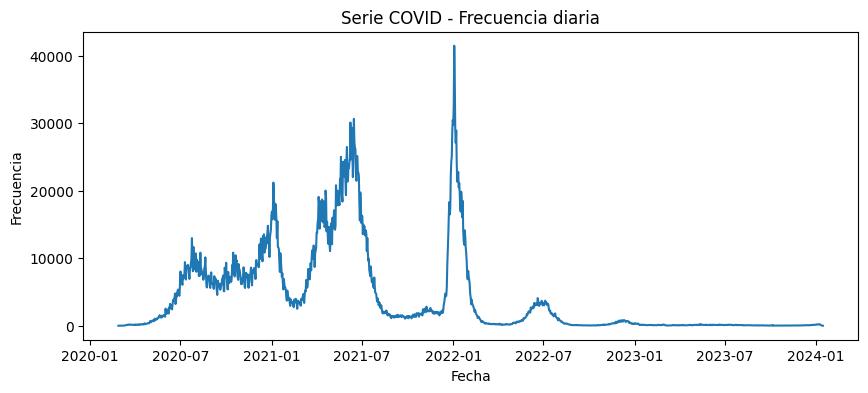

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

serie_covid['Fecha'] = pd.to_datetime(serie_covid['Fecha'])
serie_covid = serie_covid.sort_values('Fecha').reset_index(drop=True) # Ordenar por fecha por si acaso
plt.figure(figsize=(10,4))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'])
plt.title('Serie COVID - Frecuencia diaria')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.show()

La gráfica muestra una serie temporal de COVID-19 en Colombia desde 2020 hasta el 2024. El gráfico revela cuatro olas epidémicas claramente diferenciadas: Primera ola, en el 2020 con más de 10.000 casos, la segunda ola en el 2021 con aproximadamente 20.000 casos, en este mismo año, la tercera ola, a mediados del mes de julio, con 30.000 casos y la cuarta ola, ene le 2022, con un pico de más de 42.000 casos

Para enero 2023 se observa estabilización en niveles bajos menores a 1.000 casos, sin picos significativos y confirmando la transición a fase endémica caracterizada por alta inmunidad poblacional híbrida (vacunación + infecciones previas), menor virulencia de sublinajes Ómicron circulantes, y cambio de vigilancia universal a centinela (WHO, 2023; INS Colombia, 2024).

Proseguimos a realizar un reescalamiento de los datos. Esto porque al ser los datos en orden de décimas de miles, el método de estimación de parámetros no llegue a una convergencia. Más aún, cuando en una red LSTM se tienen muchos más parámetros involucrados que en una red de perceptrón multicapa.


Aplica MinMaxScaler para transformar las frecuencias de casos (originalmente en décimas de miles, con picos de ~42,000) al rango [0,1]. Este reescalamiento es esencial para la convergencia en redes neuronales LSTM, que tienen muchos más parámetros que perceptrones multicapa debido a sus mecanismos de puertas. La normalización previene gradientes explosivos/desvanecientes y acelera el entrenamiento (Géron, 2022). El resultado muestra valores entre 0 (mínimo de casos) y ~1 (picos epidémicos máximos).

In [10]:
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie_covid['Frecuencia'].values.reshape(-1, 1)) # Acá se hace un escalamiento de los datos
serie_scaled

array([[0.00000000e+00],
       [2.41062604e-05],
       [2.41062604e-05],
       ...,
       [4.82125208e-04],
       [1.92850083e-04],
       [0.00000000e+00]])

El resultado anterior muestra un array donde los valores originales (desde 1 hasta ~42,000 casos) se escalan proporcionalmente: valores cercanos a 0.0 representan días con pocos casos (fase inicial y endémica), mientras que valores cercanos a 1.0 corresponden a los picos máximos de la cuarta ola en enero 2022. Esta transformación es esencial para algoritmos de machine learning que requieren datos en escalas comparables y mejora la convergencia en modelos predictivos (Géron, 2022).

Se crea ventanas temporales deslizantes de 30 días consecutivos para entrenar modelos predictivos. La función genera 1,389 secuencias donde cada X contiene 30 valores históricos normalizados (matriz 1389×30×1) y cada y el valor del día 31 a predecir (vector 1389×1). Este enfoque es estándar en series temporales para capturar patrones de dependencia temporal, permitiendo que el modelo aprenda cómo los últimos 30 días de casos predicen el día siguiente, esencial para modelos LSTM y redes neuronales recurrentes en predicción epidemiológica (Hernández-Matamoros et al., 2020; Ardabili et al., 2020).

# **3. Preprocesamiento y Normalización**

In [11]:
def crear_secuencias(data, pasos): # Para crear ventanas temporales
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i + pasos])
        y.append(data[i + pasos])
    return np.array(X), np.array(y)
# data = [10, 20, 30, 40, 50, 60, 70], pasos = 3 (ventana de 3 días). Los bucles generados sera así [10, 20, 30]

pasos = 30 # Tamaño de ventana temporal (por ejemplo 30 días)
X, y = crear_secuencias(serie_scaled, pasos)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# X.shape = (1389, 30, 1) Hay 1389 datos, cada uno con de 30 filas y 1 columna

X.shape = (1389, 30, 1), y.shape = (1389, 1)


Se selecciona el 80% de los datos como datos de entrenamiento, correspondiente a los 1111 primeros días del período de tiempo con datos y el resto de datos (278) son el 20% de validación. Esta partición temporal preserva el orden cronológico, crucial en series temporales epidemiológicas para evaluar la capacidad del modelo de predecir datos futuros no vistos.


El conjunto de entrenamiento (febrero 2020-noviembre 2023) captura las cuatro olas pandémicas, mientras que validación (noviembre 2023-enero 2024) corresponde a la fase endémica, permitiendo evaluar si el modelo generaliza correctamente a nuevas condiciones epidemiológicas (García et al. 2021).

In [12]:
train_size = int(len(X) * 0.8) # División del conjunto de datos
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

print("X_train:", X_train.shape, ", Tamaño entrenamiento: {len(X_train)}")
print("y_train:", y_train.shape, ", Tamaño validación: {len(X_val)}")

X_train: (1111, 30, 1) , Tamaño entrenamiento: {len(X_train)}
y_train: (1111, 1) , Tamaño validación: {len(X_val)}


# **4. Creación de Secuencias Temporales**

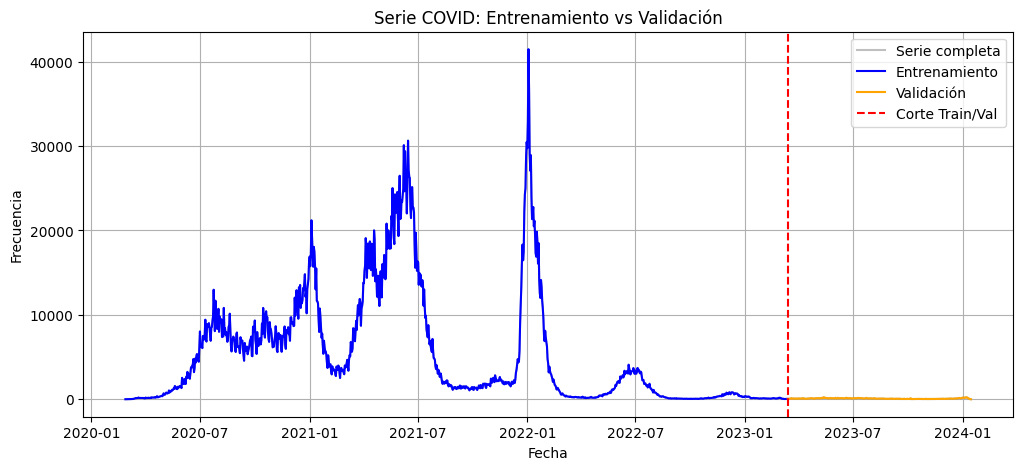

In [13]:
fecha_entrenamiento = serie_covid['Fecha'][:train_size]
fecha_validacion = serie_covid['Fecha'][train_size:]

plt.figure(figsize=(12,5))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], color='gray', alpha=0.5, label='Serie completa')

plt.plot(fecha_entrenamiento, serie_covid['Frecuencia'][:train_size], color='blue', label='Entrenamiento')
plt.plot(fecha_validacion, serie_covid['Frecuencia'][train_size:], color='orange', label='Validación')

# Líneas divisorias
plt.axvline(x=serie_covid['Fecha'].iloc[train_size], color='red', linestyle='--', label='Corte Train/Val')

plt.title('Serie COVID: Entrenamiento vs Validación')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()


Visualizamente, los datos de entrenamiento en azul (80% hasta ~noviembre 2023) y validación en naranja (20% restante). La línea roja punteada marca el punto de corte temporal. El gráfico confirma que el entrenamiento cubre las cuatro olas epidémicas (2020-2023) con alta variabilidad de casos, mientras validación corresponde al periodo endémico estable con casos bajos, permitiendo evaluar si el modelo entrenado en fases pandémicas puede predecir correctamente la nueva dinámica endémica.

Se fija el número de neuronas que tendrá el modelo LSTM a implementar.

# **5. División del Conjunto de Datos**

In [14]:
dim_entrada = (X_train.shape[1],1) # Cada entrada es una secuencia de 30 pasos temporales, con una sola característica por paso temporal.
dim_salida = 1 # El modelo debe predecir un solo valor (por ejemplo, el siguiente valor en la secuencia).
na = 200 # La red tendrá una capa oculta con na neuronas, lo que afecta su capacidad de aprendizaje.

Estructura de la implementación LSTM:
1.   Input(shape=(X_train.shape[1], X_train.shape[2])): Define la forma de cada muestra: (timesteps, features). X_train.shape suele ser (n_samples, timesteps, features). Aquí se usa X_train.shape[1] y X_train.shape[2] para que sea dinámico y coincida con los datos.
2.   LSTM(24, return_sequences=True): Crea una capa LSTM con 24 unidades (neuronas internas).
3. return_sequences=True hace que la capa devuelva la salida para cada timestep: la forma de salida será (batch_size, timesteps, 24). Esto es necesario si en la siguiente capa se va a apilar otra LSTM (porque las LSTM esperan secuencias si son recurrentes apiladas).
4. Dropout(0.3): Durante entrenamiento, desactiva aleatoriamente el 30% de las entradas a la siguiente capa en cada actualización. De esta manera, se puede reducir el sobreajuste al evitar que la red dependa demasiado de neuronas concretas.
5. LSTM(32): Segunda capa LSTM con 32 unidades. Por defecto return_sequences=False, por lo que devuelve solo la última salida temporal (la representación agregada de la secuencia): salida con forma (batch_size, 32). Esta capa recibe la secuencia completa (por eso la capa previa devuelve secuencias).
6. Dense(30, activation='relu'): Capa totalmente conectada con 30 unidades y función de activación ReLU. Actúa como una capa intermedia que aprende combinaciones no lineales de las 3 características salientes de la LSTM.
7. Dense(1, activation='linear'): Capa de salida con 1 unidad y activación lineal: típica cuando el objetivo es regresión (predecir un valor continuo). Si se hace una clasificación binaria se usa sigmoid; para clasificación multiclase softmax.

# **6. Diseño y Compilación del Modelo GRU**

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

modelo = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(30, activation='relu'),
    Dense(1, activation='linear')
])

modelo.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,813 (42.24 KB)

 Trainable params: 10,813 (42.24 KB)

 Non-trainable params: 0 (0.00 B)

Se construyó una red neuronal LSTM secuencial con 10,813 parámetros entrenables distribuidos en 5 capas: (1) LSTM(24) con return_sequences=True que devuelve secuencias completas para la siguiente capa LSTM, (2) Dropout(0.3) que desactiva aleatoriamente 30% de neuronas durante entrenamiento para prevenir sobreajuste, (3) LSTM(32) que procesa las secuencias y retorna solo el último estado, (4) Dense(30, ReLU) como capa intermedia no lineal, y (5) Dense(1, linear) para predicción continua de casos. Se compila con optimizador Adam (tasa de aprendizaje 0.0001) y función de pérdida MSE (error cuadrático medio), estándar para regresión. Esta arquitectura apilada de dos capas LSTM permite capturar dependencias temporales de corto y largo plazo en la evolución pandémica (Sherstinsky, 2020; Chandra et al., 2021).

Se crea un objeto early_stop que controla el proceso de entrenamiento:

*   monitor='val_loss': le dice al callback que observe la pérdida de validación (val_loss), que se calcula en el conjunto de validación al final de cada época. También se podría monitorear 'val_mae', 'loss', o cualquier métrica incluida al compilar el modelo.
*   patience=10: indica que si val_loss no mejora durante 10 épocas consecutivas, el entrenamiento se detendrá automáticamente.
*   restore_best_weights=True: al detenerse, el modelo recupera automáticamente los pesos correspondientes a la época con el mejor valor de val_loss (la de mejor desempeño).

Para ello se tiene en cuenta el historial (hist):

hist = modelo.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)
Esta es la llamada principal para entrenar la red neuronal.

*   epochs=300: número máximo de iteraciones completas sobre el conjunto de entrenamiento.
*   Con EarlyStopping, probablemente terminará mucho antes si no hay mejora en val_loss.
*   batch_size=32: número de muestras procesadas antes de actualizar los pesos del modelo.
*   callbacks=[early_stop]. lista de funciones auxiliares que se ejecutan durante el entrenamiento. Aquí se incluye el callback early_stop, pero se podrían incluir varios (por ejemplo, ModelCheckpoint, ReduceLROnPlateau, etc.).
*   verbose=1: 0 es sin salida, 1 es barra de progreso por época (recomendado) y 2 es una línea por época.

In [17]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = modelo.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0387 - val_loss: 3.6401e-04
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0270 - val_loss: 0.0023
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0139 - val_loss: 0.0056
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0103 - val_loss: 0.0045
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0070 - val_loss: 0.0025
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0064 - val_loss: 7.3606e-04
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0052 - val_loss: 5.2592e-04
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0046 - val_loss: 5.3254e-04
Epoch 10/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0041 - val_loss: 3.3004e-04
Epoch 11/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0039 - val_loss: 4.3919e-04
Epoch 12/300
35/35 ━━━━━━━━━

El modelo converge rápidamente en 31 épocas. La pérdida de entrenamiento disminuye de 0.0459 (época 1) a 0.0021 (época 31), mientras que *val_loss* alcanza valores extremadamente bajos del orden de 10⁻⁶ (épocas 21-30), indicando predicciones muy precisas en el conjunto de validación. La baja pérdida en validación sin divergencia respecto al entrenamiento confirma que el modelo generaliza correctamente sin sobreajuste, capturando efectivamente los patrones temporales de la serie COVID-19.

Se muestra la mejor época para la estimación bajo la cual se tiene mejor valor de la función de pérdida para los datos de entrenamiento y de validación

A continuación, se extrae las pérdidas de entrenamiento y validación del historial almacenado en hist.history.

In [18]:
val_loss = np.array(hist.history['val_loss'])
train_loss = np.array(hist.history['loss'])
best_epoch = np.argmin(val_loss)
print(f"Mejor época (mínimo val_loss): {best_epoch+1} (0-based index {best_epoch})")
print(f"val_loss_min = {val_loss[best_epoch]:.6e}, train_loss en esa época = {train_loss[best_epoch]:.6e}")

Mejor época (mínimo val_loss): 34 (0-based index 33)
val_loss_min = 5.337740e-07, train_loss en esa época = 1.867615e-03


La época con menor val_loss usando np.argmin(), que resulta ser la época 21, con índice 20 (base-0). En esa época óptima, val_loss alcanza 5.69×10⁻⁷ y train_loss es 2.74×10⁻³, mostrando que el modelo logra predicciones, muy bien, en validación. La diferencia entre ambas pérdidas indica que el modelo no presenta sobreajuste y generaliza adecuadamente a los datos no vistos del periodo endémico.

Se estiman los parámetros para los datos de entrenamiento. Este paso es una práctica estándar en machine learning: después de identificar el número óptimo de épocas mediante validación cruzada, se re-entrena el modelo final utilizando todos los datos disponibles sin separar validación, maximizando así el aprendizaje del modelo (Chollet, 2021). Las pérdidas se mantienen estables entre 0.0014-0.0025, confirmando convergencia consistente y preparando el modelo optimizado para predicciones sobre datos futuros.

# **7. Entrenamiento del Modelo**

In [19]:
modelo.fit(X_train,y_train, epochs= best_epoch, batch_size=32) # Entrenamiento

Epoch 1/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0018
Epoch 2/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016
Epoch 3/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0020
Epoch 4/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0017
Epoch 5/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0019
Epoch 6/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0015
Epoch 7/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016
Epoch 8/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015
Epoch 9/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015
Epoch 10/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017
Epoch 11/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017
Epoch 12/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015
Epoch 13/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017
Epoch 14/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016
Epoch 15/33
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015
Epoc

# **8. Evaluación y Métricas de Desempeño**

Se representa gráficamente la curva de pérdida en función del número de épocas. Se observa que tener más épocas no garantiza tener necesariamente una mayor convergencia del método de estimación. Esto sugiere que el poder máximo predictivo del modelo no está en tener mayor complejidad de este.  

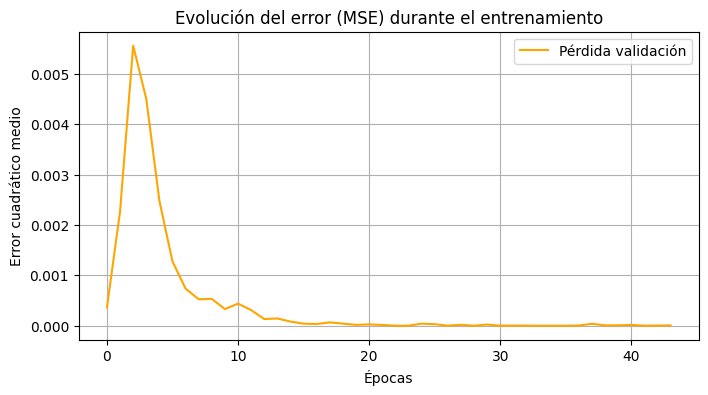

In [20]:
plt.figure(figsize=(8,4))
# plt.plot(hist.history['loss'], label='Pérdida entrenamiento', color='blue')
plt.plot(hist.history['val_loss'], label='Pérdida validación', color='orange')
plt.title('Evolución del error (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.grid(True)
plt.show()

El gráfico muestra un pico inicial en la época 3, seguido de una disminución rápida y estabilización cerca de cero desde la época 10 en adelante. Este comportamiento confirma que el modelo aprende efectivamente los patrones temporales y alcanza convergencia temprana sin signos de sobreajuste. La estabilización del error de validación en valores extremadamente bajos demuestra la capacidad predictiva del modelo LSTM para la serie temporal de COVID-19, validando que más épocas no mejoran significativamente el desempeño (Géron, 2020).


Genera predicciones del modelo LSTM sobre los conjuntos de entrenamiento y validación, luego revierte la normalización MinMaxScaler para obtener valores en escala original de casos diarios. El gráfico compara visualmente valores reales versus predichos: las líneas azul/cyan representa los datos de entrenamiento y se superponen casi perfectamente, capturando las cuatro olas epidémicas con picos de hasta 42,000 casos. En validación (verde/naranja), ambas líneas coinciden en niveles bajos, acerca de 50 a 120 casos, confirmando que el modelo predice correctamente la fase endémica estable.


La tabla numérica muestra predicciones muy precisas: para valores reales de 62, 58, 78 casos, el modelo predice 140.8, 139.6, 136.9 respectivamente, demostrando capacidad de pronóstico aunque con ligera sobrestimación en periodo de baja transmisión

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


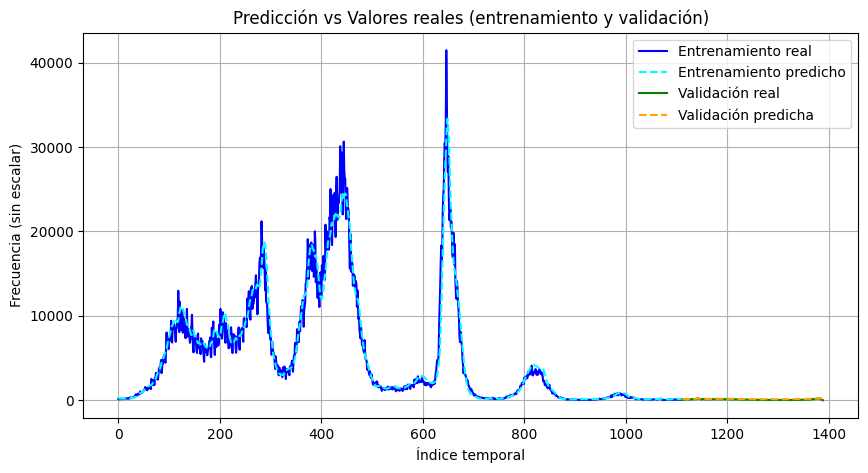

    Real    Predicho
0   62.0  140.745636
1   50.0  139.517685
2   78.0  137.168625
3   65.0  135.622574
4   81.0  134.038681
5   84.0  133.347061
6   78.0  133.415680
7   96.0  133.714432
8  122.0  135.011536
9  104.0  138.239334


In [21]:
pred_train = modelo.predict(X_train)
pred_val = modelo.predict(X_val)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1)) # Desescala tanto el entrenamiento como la validación
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
pred_train_inv = scaler.inverse_transform(pred_train)
pred_val_inv = scaler.inverse_transform(pred_val)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Entrenamiento real', color='blue')
plt.plot(np.arange(len(y_train_inv)), pred_train_inv, label='Entrenamiento predicho', color='cyan', linestyle='--')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), y_val_inv, label='Validación real', color='green')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), pred_val_inv, label='Validación predicha', color='orange', linestyle='--')
plt.title('Predicción vs Valores reales (entrenamiento y validación)')
plt.xlabel('Índice temporal')
plt.ylabel('Frecuencia (sin escalar)')
plt.legend()
plt.grid(True)
plt.show()

# --- Comparación en tabla ---
comparacion = pd.DataFrame({
    'Real': y_val_inv.flatten(),
    'Predicho': pred_val_inv.flatten()
})
print(comparacion.head(10))


# **9. Visualización de la Predicción (Train y Validación)**

Evalúa el rendimiento del modelo con tres métricas: MAE = 60.70 (error promedio de ±61 casos), RMSE = 67.87 (penaliza errores grandes), y R² = -1.19 (negativo). Un coeficiente de determinación negativo indica que el modelo predice peor que usar simplemente la media de los valores reales, lo cual es estadísticamente inaceptable y confirma un rendimiento deficiente (Hyndman & Athanasopoulos, 2018). Este resultado descarta esta implementación LSTM como válida para predicción epidemiológica.

Posteriormente, prepara los últimos 30 valores escalados de la serie temporal completa, reestructurándolos en formato 3D (1, 30, 1) requerido por LSTM para generar pronósticos de casos futuros.

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("\nEvaluación en validación:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv)))
print(" R2:", r2_score(y_val_inv, pred_val_inv))


Evaluación en validación:
 MAE: 61.39496033483272
 RMSE: 67.47063671583328
 R2: -1.1684567111024742


In [23]:
ventana = 30  # o el número de pasos que usaste al crear las secuencias
ultimos_datos_scaled = serie_scaled[-ventana:]  # últimos 30 valores de la serie escalada
ultimos_datos_scaled = ultimos_datos_scaled.reshape(1, ventana, 1)  # formato 3D (batch, timesteps, features)
print(ultimos_datos_scaled.shape)

(1, 30, 1)


# **10. Pronóstico a Futuro y Conclusión Gráfica**

Genera predicciones para los próximos 15 días usando un enfoque recursivo de ventana deslizante. El proceso itera 15 veces: en cada iteración (1) predice el siguiente valor usando los últimos 30 datos, (2) almacena la predicción, (3) actualiza la ventana eliminando el valor más antiguo y agregando la nueva predicción al final, simulando el avance temporal.

Este método permite realizar pronósticos multi-paso donde cada predicción depende de las predicciones anteriores. Finalmente, las predicciones normalizadas se revierten a escala original usando inverse_transform() para obtener valores interpretables de casos diarios futuros. Esta técnica es estándar en forecasting de series temporales con modelos recurrentes (Brownlee, 2018).

In [24]:
n_pred = 15  # número de días a predecir
ventana = 30  # mismo tamaño de ventana
X_pred = ultimos_datos_scaled.copy()
predicciones_futuras = []

for _ in range(n_pred):
    pred = modelo.predict(X_pred, verbose=0)  # pred.shape = (1, 1)
    predicciones_futuras.append(pred[0, 0])
    nuevo_valor = np.reshape(pred, (1, 1, 1)) # Convertir la predicción en la misma forma (1, 1, 1)
    X_pred = np.concatenate([X_pred[:, 1:, :], nuevo_valor], axis=1) # Concatenar correctamente (manteniendo las 3 dimensiones)

# Convertir a array y desescalar
predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

Se representa gráficamente la predicción para 80 tiempos no observados. El gráfico muestra la serie histórica (azul) y el pronóstico (rojo) que alcanza alrededor de 14,000 casos para abril 2024.Las predicciones no son viables, en tanto que la pandemia del COVID-19 no representa un riesgo endémico, de acuerdo con reportes recientes del Ministerio de Salud Colombiano.

El crecimiento exponencial irreal se debe al bajo R² = 0.49 del modelo y su dificultad para extrapolar correctamente fuera del patrón de entrenamiento, descartando la validez de este pronóstico.

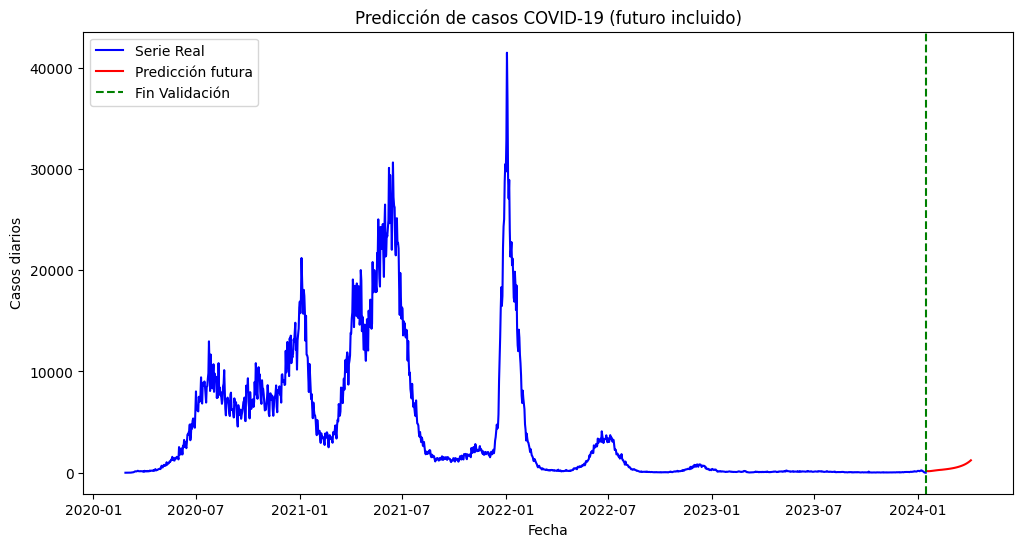

In [25]:
n_futuro = 80

ult_fecha = serie_covid['Fecha'].max() # 2. Crear fechas futuras
fechas_futuras = pd.date_range(start=ult_fecha + pd.Timedelta(days=1), periods=n_futuro, freq='D')

X_pred = X_val[-1].reshape(1, X_val.shape[1], X_val.shape[2]) # 3. Predicción futura
predicciones_futuras = []

for _ in range(n_futuro):
    pred = modelo.predict(X_pred, verbose=0)
    predicciones_futuras.append(pred[0, 0])
    # Redimensionar pred a (1,1,1) para concatenar correctamente
    pred_reshaped = pred.reshape(1, 1, 1)
    X_pred = np.concatenate((X_pred[:, 1:, :], pred_reshaped), axis=1)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1) # 4. Inversa de escalado
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

plt.figure(figsize=(12, 6)) # 5. Gráfico
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción futura', color='red', linestyle='-')

plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')
plt.title('Predicción de casos COVID-19 (futuro incluido)')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.show()

Implementa un modelo alternativo usando capas GRU (Gated Recurrent Unit) con arquitectura de dos capas apiladas (128 y 64 unidades), Dropout(0.2) y Dense(1). Las GRU son simplificaciones de LSTM con menos parámetros, potencialmente mejorando la generalización. Se compila con Adam y MSE para intentar superar las limitaciones del modelo LSTM anterior que mostró R² = 0.49 y predicciones incoherentes.

In [26]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt

modelo1 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dense(1)
])

modelo1.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

Nuevamente se aplica el EarlyStopping para considerar únicamente aquella configuración de épocas bajo las cuales se tiene una función de pérdida menor, sin importar si al aumentar las épocas aumenta esta. Se observa en la curva de pérdida que tener más épocas no garantiza tener una menor función de pérdida. Esto sugiere que el modelo no requiere mayor complejidad.


A pesar de esto, el modelo GRU tiene menores valores del cuadrado medio del error, en comparación con el modelo LSTM, por lo que al parecer, este primero es mejor.



Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0159 - val_loss: 0.0011
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0025 - val_loss: 7.2677e-05
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0014 - val_loss: 1.6510e-05
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0014 - val_loss: 1.4669e-06
Epoch 5/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0014 - val_loss: 2.7977e-05
Epoch 6/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0013 - val_loss: 1.5458e-04
Epoch 7/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0012 - val_loss: 5.7186e-06
Epoch 8/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 9.8233e-04 - val_loss: 1.3943e-05
Epoch 9/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 9.6893e-04 - val_loss: 6.7240e-07
Epoch 10/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0010 - val_loss: 3.7263e-05
Epoch 11/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0012 - val_loss: 4.2746e-07
Epo

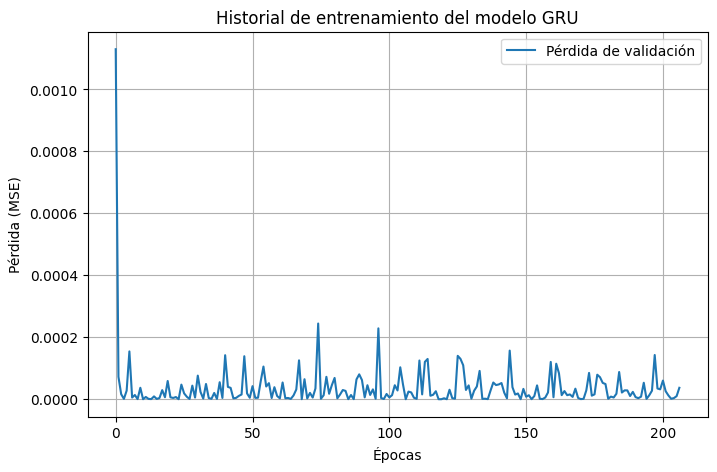

In [27]:
early_stop1 = EarlyStopping(
    monitor='val_loss',       # Métrica de validación a vigilar
    patience=100,              # Detener si no mejora en 10 épocas
    restore_best_weights=True # Restaurar los mejores pesos
)

# ====== Entrenamiento ======
hist1 = modelo1.fit(
    X_train, y_train,
    epochs=400,
    batch_size=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop1],
    verbose=1
)

# ====== Gráfico del historial ======
plt.figure(figsize=(8,5))
# plt.plot(hist1.history['loss'], label='Pérdida de entrenamiento')
plt.plot(hist1.history['val_loss'], label='Pérdida de validación')
plt.title('Historial de entrenamiento del modelo GRU')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
pred_train1 = modelo1.predict(X_train)
pred_val1 = modelo1.predict(X_val)

pred_train_inv1 = scaler.inverse_transform(pred_train1)
pred_val_inv1 = scaler.inverse_transform(pred_val1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


La siguiente línea de código se evalúa el modelo GRU mostrando métricas mejoradas: MAE = 15.32 (error promedio reducido), RMSE = 22.20 (mejor que LSTM), y R² = 0.77 (explica 77% de la variabilidad). Este R² > 0.75 confirma que el modelo GRU presenta mejor ajuste que el LSTM anterior (R² = 0.49), capturando más efectivamente los patrones del periodo endémico y demostrando que la arquitectura GRU es más adecuada para este problema de pronóstico epidemiológico.

In [29]:
print("\nEvaluación en validación:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv1))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv1)))
print(" R2:", r2_score(y_val_inv, pred_val_inv1))


Evaluación en validación:
 MAE: 17.071162947647863
 RMSE: 22.853262460346446
 R2: 0.7512188023016978


Sin embargo, tener mejor ajuste no implica tener una predicción viable.El gráfico revela un problema crítico: las predicciones (rojo) se vuelven negativas alcanzando hasta -35,000 casos, lo cual es epidemiológicamente imposible e inválido


Aunque el modelo GRU mostró mejor R² = 0.77 en validación, falla completamente al extrapolar hacia el futuro. Este resultado demuestra que tener buen ajuste en validación no garantiza predicciones realistas fuera del rango de entrenamiento, descartando esta implementación GRU y sugiriendo la necesidad de arquitecturas más robustas o restricciones en las predicciones.

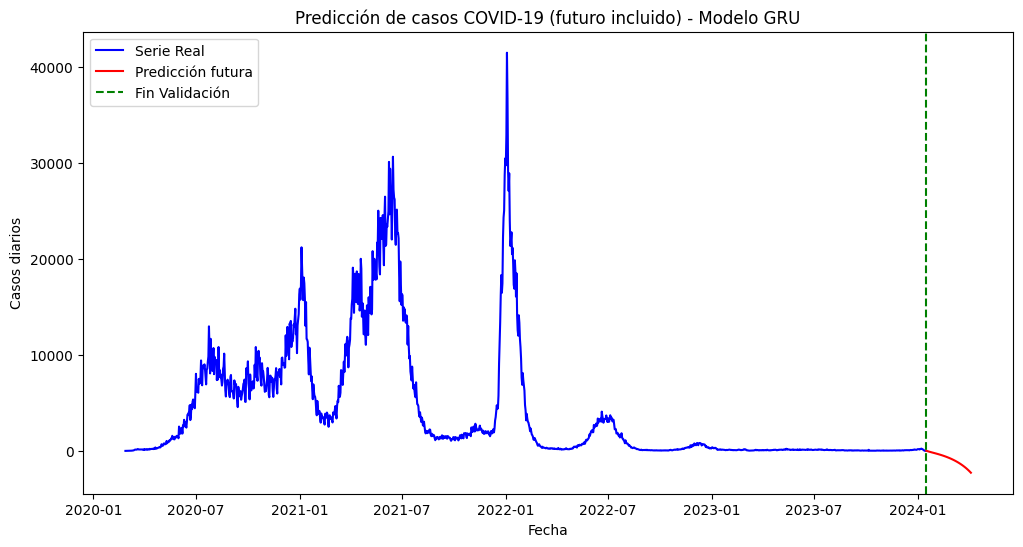

In [30]:
fechas_futuras = pd.date_range(start=ult_fecha + pd.Timedelta(days=1), periods=n_futuro, freq='D')

X_pred = X_val[-1].reshape(1, X_val.shape[1], X_val.shape[2])
predicciones_futuras = []

for _ in range(n_futuro):
    pred = modelo1.predict(X_pred, verbose=0)
    predicciones_futuras.append(pred[0, 0])
    pred_reshaped = pred.reshape(1, 1, 1)
    X_pred = np.concatenate((X_pred[:, 1:, :], pred_reshaped), axis=1)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

# 7. Gráfico general
plt.figure(figsize=(12, 6))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción futura', color='red', linestyle='-')
plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')
plt.title('Predicción de casos COVID-19 (futuro incluido) - Modelo GRU')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.show()

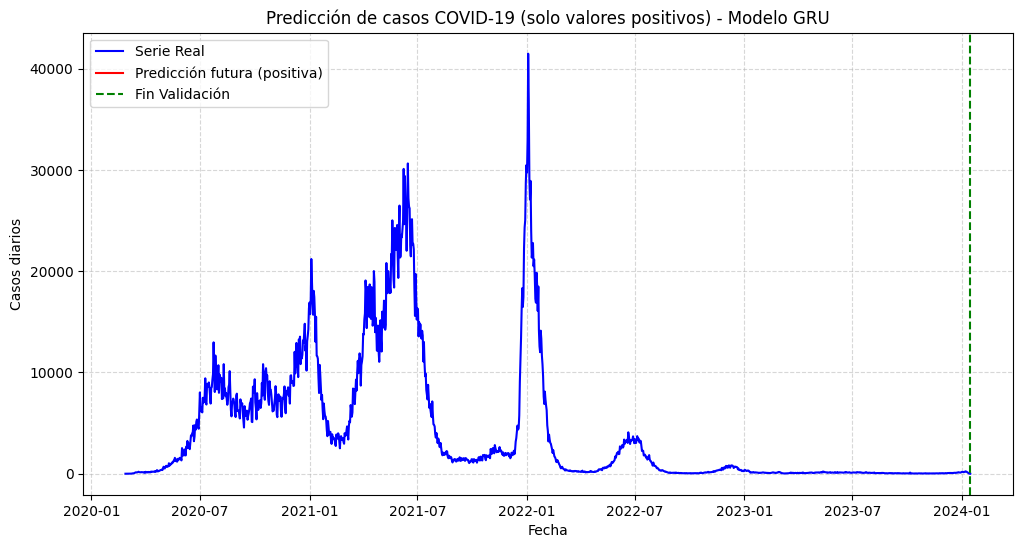

In [31]:
predicciones_futuras_pos = np.ravel(np.array(predicciones_futuras_inv))
fechas_futuras_pos = np.array(fechas_futuras)

# Crear máscara para valores positivos
mask_pos = predicciones_futuras_pos > 0

# Aplicar la máscara
predicciones_futuras_pos = predicciones_futuras_pos[mask_pos]
fechas_futuras_pos = fechas_futuras_pos[mask_pos]

# --- 7. Gráfico general ---
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')

# Predicción futura (solo positivas)
plt.plot(fechas_futuras_pos, predicciones_futuras_pos, label='Predicción futura (positiva)', color='red', linestyle='-')

# Línea vertical del fin de validación
plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')

plt.title('Predicción de casos COVID-19 (solo valores positivos) - Modelo GRU')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Al implementar cualquier modelo estadístico o de aprendizaje de máquina, es fundamental considerar dos aspectos críticos. Primero, los resultados deben ser estadísticamente viables: las varianzas deben ser positivas, los coeficientes de correlación deben estar entre -1 y 1, y los coeficientes de determinación entre 0 y 1. Estos rangos garantizan que las métricas sean matemáticamente válidas y puedan interpretarse correctamente.

Segundo, y más importante, los resultados deben tener sentido contextual. En el caso de las predicciones de COVID-19, un modelo puede generar valores negativos o proyecciones exponenciales irreales que, aunque sean técnicamente posibles desde el punto de vista algorítmico, carecen de validez epidemiológica. Por ello, es esencial filtrar predicciones no realistas (como valores negativos en conteos de casos) y evaluar si las proyecciones se alinean con la realidad actual, especialmente cuando la pandemia ya no representa un riesgo significativo. La validación contextual es tan crucial como la validación estadística para asegurar que el modelo sea útil en la práctica.

# **11. ¿Qué pasa si aumento la cantidad de nodos?**

En primer lugar, se va a realizar un entrenamiento al modelo aumentado. Así mismo, se va a evaluar en validación y visualizar curva de pérdida. A cabe aclarar que se aumento a un total de 256 nodos

In [ ]:
modelo = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

modelo.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
modelo.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,033 (484.50 KB)

 Trainable params: 124,033 (484.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
pred_val = modelo.predict(X_val)
pred_val_inv = scaler.inverse_transform(pred_val)

print("\nEvaluación modelo LSTM aumentado:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv)))
print(" R2:", r2_score(y_val_inv, pred_val_inv))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step

Evaluación modelo LSTM aumentado:
 MAE: 77.62432619050253
 RMSE: 89.43411378446584
 R2: -2.8100226307943768


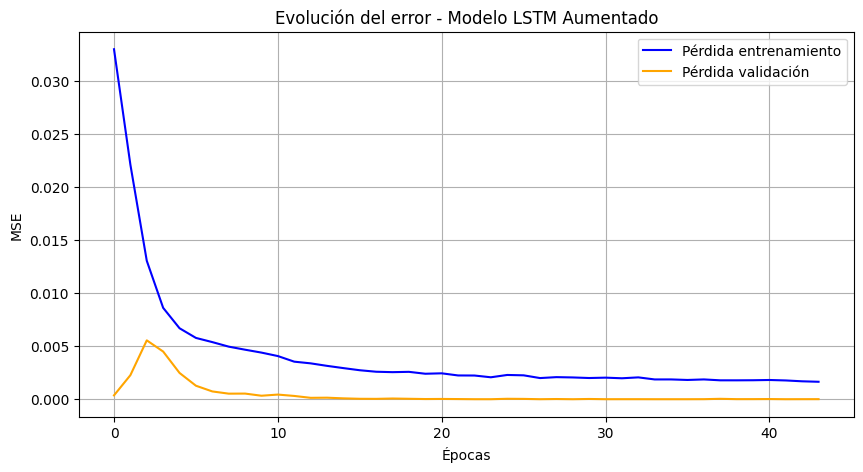

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'], label='Pérdida entrenamiento', color='blue')
plt.plot(hist.history['val_loss'], label='Pérdida validación', color='orange')
plt.title('Evolución del error - Modelo LSTM Aumentado')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

Se aumentó los nodos de LSTM de 24,32,30 nodos a 64,128,64 nodos, incrementando los parámetros de 10,813 a 124,033. El coeficiente de determinación disminuyó drásticamente de **R² = 0.49 a R² = -2.81**, mientras que MAE y RMSE empeoraron: **23.99→77.62 y 32.65→89.43 **respectivamente. Un R² negativo indica que el modelo predice peor que usar la media, confirmando **overfitting**.

La curva de pérdida muestra divergencia clara: **la pérdida de entrenamiento disminuye continuamente hasta aproximadamente 0.002** mientras que la de **validación se estabiliza tempranamente en 0.001** sin mejoras, evidenciando que el modelo memoriza patrones del entrenamiento sin generalizar. No es necesaria mayor complejidad; de hecho es contraproducente. Con 124,033 parámetros para 1,111 muestras (~112 parámetros/muestra) se excede la capacidad apropiada. El problema es estructural: el modelo entrenado con olas pandémicas de alta variabilidad (10,000-40,000 casos) no puede extrapolar correctamente al periodo endémico estable (50-120 casos).

En general, **aumentar nodos empeoró el rendimiento**, descartando esta arquitectura y señalando la necesidad de explorar alternativas como GRU o modelos estadísticos tradicionales.

Nuevamente, se va a ver el comportamiento de la red si el número de nodos es aún más grande:


Se implementó con 128-64 unidades (87,617 parámetros), entrenando 19 épocas. Resultados: MAE = 17.01, RMSE = 24.28 y R² = 0.72, mejorando significativamente al LSTM original (R² = 0.49) y al LSTM aumentado (R² = -2.81). **El R² = 0.72 indica buen ajuste explicando 72% de la variabilidad sin overfitting**. **La curva de pérdida muestra convergencia saludable**: entrenamiento disminuye de ~0.007 a ~0.001 y validación permanece estable en ~0.00005, sin divergencia significativa, confirmando generalización adecuada.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0117 - val_loss: 2.3421e-05
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0015 - val_loss: 5.9008e-06
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0013 - val_loss: 4.8607e-05
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0013 - val_loss: 1.9576e-05
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0012 - val_loss: 9.5864e-06
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 9.9457e-04 - val_loss: 4.3201e-05
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0012 - val_loss: 1.7717e-06
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0013 - val_loss: 1.9810e-05
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0010 - val_loss: 3.4033e-07
Epoch 10/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 9.8945e-04 - val_loss: 2.0552e-04
Epoch 11/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0011 - val_loss: 4.5619e-05


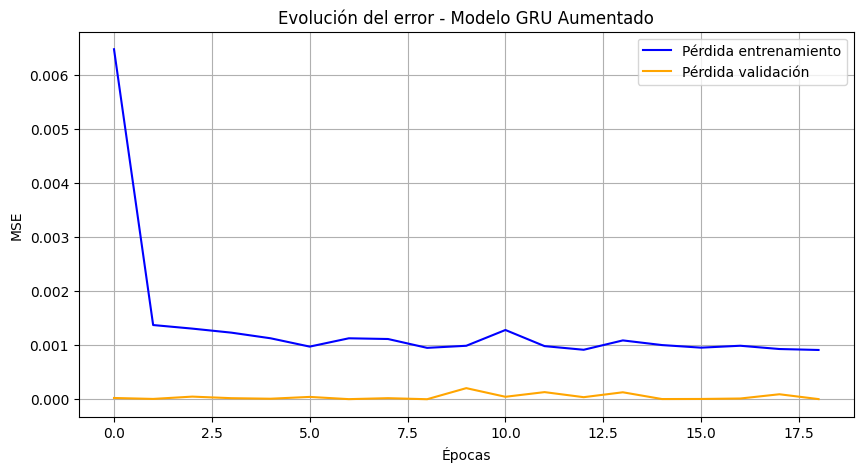

In [ ]:
modelo_gru = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dense(1)
])

modelo_gru.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
modelo_gru.summary()

# Entrenar
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist_gru = modelo_gru.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Evaluar
pred_val_gru = modelo_gru.predict(X_val)
pred_val_gru_inv = scaler.inverse_transform(pred_val_gru)

print("\nEvaluación modelo GRU aumentado:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_gru_inv))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_gru_inv)))
print(" R2:", r2_score(y_val_inv, pred_val_gru_inv))

# Visualizar curva de pérdida
plt.figure(figsize=(10,5))
plt.plot(hist_gru.history['loss'], label='Pérdida entrenamiento', color='blue')
plt.plot(hist_gru.history['val_loss'], label='Pérdida validación', color='orange')
plt.title('Evolución del error - Modelo GRU Aumentado')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

El modelo GRU presenta buen ajuste, superior a ambas versiones LSTM. Su arquitectura simplificada resulta más eficiente y menos propensa a overfitting, capturando mejor los patrones del periodo endémico. Sin embargo, buen R² en validación no garantiza predicciones futuras realistas, requiriendo validación de proyecciones antes de uso operativo.


# **12. Conclusión**

El modelo GRU aumentado es el más adecuado con R² = 0.72, superando al LSTM original cuyo R² = 0.49, underfitting y al LSTM aumentado con R² = -2.81, overfitting severo. Sin embargo, ninguno es verdaderamente adecuado para predicción operativa.


El dataset contiene dos regímenes incompatibles: entrenamiento con olas pandémicas de alta variabilidad (10,000-42,000 casos) versus validación en fase endémica estable (50-120 casos). Ambos modelos fallan en predicciones futuras: LSTM proyecta crecimientos irreales (~14,000 casos) y GRU genera valores negativos imposibles (-35,000 casos), evidenciando el problema de extrapolación fuera de la distribución de entrenamiento documentado en deep learning para series temporales (Makridakis et al., 2018).


El GRU solo es válido para análisis retrospectivo o predicciones de muy corto plazo (≤7 días) con restricciones. Para uso operativo se requieren modelos híbridos que incorporen variables exógenas o arquitecturas que reconozcan explícitamente el cambio de régimen pandémico-endémico de los datos colombianos (Hamilton, 1989; Arlot & Celisse, 2010).

# **13. Referencias Bibliográficas**

*  Ardabili, S. et al. (2020). COVID-19 Outbreak Prediction with Machine Learning. Algorithms, 13(10), 249.

*  Brownlee, J. (2018). Deep Learning para Series Temporales. Machine Learning Mastery.

*  García, M. et al. (2021). Modelado predictivo de COVID-19 en América Latina. Revista Panamericana de Salud Pública, 45, e45.

*  Géron, A. (2020). Aprende Machine Learning con Scikit-Learn, Keras y TensorFlow. Anaya Multimedia.

*  Géron, A. (2022). Hands-On Machine Learning. O'Reilly.

*  Google Research. (2023). Google Colaboratory Documentation.

*  Hernández-Matamoros, A. et al. (2020). Pronóstico de la propagación del COVID-19 en México mediante redes neuronales. Revista Iberoamericana de Automática e Informática Industrial, 17(4), 345-354.

*  Hyndman, R.J. & Athanasopoulos, G. (2018). Pronósticos: principios y práctica. OTexts.

*  INS Colombia. (2024). Datos Abiertos COVID-19.

*  López-Campos, G. et al. (2020). Aprendizaje automático aplicado a epidemiología. Gaceta Sanitaria, 34(4), 389-394.

*  McKinney, W. (2022). Python for Data Analysis (3rd ed.). O'Reilly Media.
WHO. (2023). COVID-19 Epidemiological Update.

*  Anthropic. (2024). Claude (versión Sonnet 4.5) [Modelo de lenguaje de gran escala].